# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/Recent/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\SubSet\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [7]:
files = os.listdir(folder)
#files=files[15:30]

In [8]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [9]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.0086):
    SquelchSignal = []

    for i in range(StallRange):
        SquelchSignal.append(1)

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+2*StallRange]) < SquelchLevel:
            SquelchSignal.append(0)
        else:
            SquelchSignal.append(1)

    for i in range(StallRange+1):
        SquelchSignal.append(1)    
    
    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    if len(Timestamps) == 1:
        dTime = Timestamps
    elif len(Timestamps) == len(Acceleration):
        totTime = 0
        for i in range(len(Timestamps)-1):
            if Timestamps[i]<Timestamps[i+1]:
                totTime += (Timestamps[i+1] - Timestamps[i])
            else:
                totTime += (Timestamps[i+1] - Timestamps[i] + 10000)
        dTime = totTime / len(Timestamps)
    else:
        print('error')

    dTime = dTime / 10000.0

    velocity[0] = Acceleration[0] * (dTime)

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity



In [10]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        #try: 
        ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
        SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        StdDevsX = RollingStdDev(ODataSet[:,3],SmoothX)
        StdDevsY = RollingStdDev(ODataSet[:,4],SmoothY)
        StdDevsZ = RollingStdDev(ODataSet[:,5],SmoothZ)
        StdDevsX.append(0)
        StdDevsY.append(0)
        StdDevsZ.append(0)
        StdDevsX = np.asarray(StdDevsX)
        StdDevsY = np.asarray(StdDevsY)
        StdDevsZ = np.asarray(StdDevsZ)
        SmoothDevX = denoise_wavelet(StdDevsX, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothDevY = denoise_wavelet(StdDevsY, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        RollSumStdDevX = RollingSum(SmoothDevX)
        RollSumStdDevX = np.asarray(RollSumStdDevX)
        RollSumStdDevY = RollingSum(SmoothDevY)
        RollSumStdDevY = np.asarray(RollSumStdDevY)
        RollSumStdDevZ = RollingSum(SmoothDevZ)
        RollSumStdDevZ = np.asarray(RollSumStdDevZ)
        SquelchSignal = SquelchPattern(SmoothDevX, 3000, 0.01)
        Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        Velocity = np.asarray(Velocity)

        #except:
        #    Velocity = file
        #    StdDevsX = 0
        #    RollSumStdDevX = 0
        #    StdDevsY = 0
        #    RollSumStdDevY = 0
        #    StdDevsZ = 0
        #    RollSumStdDevZ = 0
        #    print(file)
        return [Velocity, [StdDevsX, StdDevsY, StdDevsZ], [RollSumStdDevX,RollSumStdDevY,RollSumStdDevZ]]
    else:
        pass

import os
import datetime as dt

fi2 = []

now = dt.datetime.now()
ago = now-dt.timedelta(days=60) #last run 1/19

for root, dirs,files in os.walk(folder):  
    for fname in files:
        path = os.path.join(root, fname)
        st = os.stat(path)    
        mtime = dt.datetime.fromtimestamp(st.st_ctime)
        if mtime > ago:
            fi2.append(fname)

In [11]:
LoopFiles = 12
loops = int(len(files) / LoopFiles) +1

In [12]:
rootfolder

'/sciclone/home/dchendrickson01/'

In [13]:
NeedHeader = True
if os.path.exists(rootfolder + 'StdDevBySpeedSummaryStatistics5.csv'):
    NeedHeader=False

WriteFile = open(rootfolder + 'StdDevBySpeedSummaryStatistics5.csv','a')
if NeedHeader:
    WriteFile.write('Year, Month, Day, Sensor, am, np.average(MovingDevX), np.average(StopedDevX), np.average(MovingDevY), np.average(StopedDevY), np.average(MovingDevY), np.average(StopedDevY), DevX0, DevX1, DevX2, DevX3, DevX4, DevX5p,DevY0, DevY1, DevY2, DevY3, DevY4, DevY5p,DevZ0, DevZ1, DevZ2, DevZ3, DevZ4, DevZ5p \n')

#k = 22
#LoopFiles = 12

In [14]:
WriteFile

st = ti()

#loops = 30
bump = 0
#LoopFiles = 1

In [15]:
loops

7

In [16]:
for j in range(loops):
    k = j
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    Velocities = []
    StdDevsX = []
    SumStdDevsX = []
    StdDevsY = []
    SumStdDevsY = []
    StdDevsZ = []
    SumStdDevsZ = []
    NewFiles=[]

    for i in range(len(Results)):
        if Results[i] != None:
            Velocities.append(Results[i][0])
            StdDevsX.append(Results[i][1][0])
            SumStdDevsX.append(Results[i][2][0])
            StdDevsY.append(Results[i][1][1])
            SumStdDevsY.append(Results[i][2][1])
            StdDevsZ.append(Results[i][1][2])
            SumStdDevsZ.append(Results[i][2][2])
            NewFiles.append(tfiles[i])
    MaxDevX=[]
    MaxRollX=[]
    MaxDevY=[]
    MaxRollY=[]
    MaxDevZ=[]
    MaxRollZ=[]
    for i in range(len(StdDevsZ)):
        MaxDevX.append(np.max(StdDevsX[i]))
        MaxRollX.append(np.max(SumStdDevsX[i]))
        MaxDevY.append(np.max(StdDevsY[i]))
        MaxRollY.append(np.max(SumStdDevsY[i]))
        MaxDevZ.append(np.max(StdDevsZ[i]))
        MaxRollZ.append(np.max(SumStdDevsZ[i]))
    
    Results = []
    for i in range(len(MaxDevZ)):
        if MaxDevX[i] != 0:
            UnitSpeeds = np.abs(Velocities[i]).astype('int')
            MovingDevX = StdDevsX[i][np.abs(Velocities[i]) > 1]
            StopedDevX = StdDevsX[i][np.abs(Velocities[i]) < 1]
            MovingDevY = StdDevsY[i][np.abs(Velocities[i]) > 1]
            StopedDevY = StdDevsY[i][np.abs(Velocities[i]) < 1]
            MovingDevZ = StdDevsZ[i][np.abs(Velocities[i]) > 1]
            StopedDevZ = StdDevsZ[i][np.abs(Velocities[i]) < 1]
            DevX0 = np.average(StdDevsX[i][UnitSpeeds < 1])
            DevX1 = np.average(StdDevsX[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
            DevX2 = np.average(StdDevsX[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
            DevX3 = np.average(StdDevsX[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
            DevX4 = np.average(StdDevsX[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
            DevX5p = np.average(StdDevsX[i][UnitSpeeds >= 3])
            DevY0 = np.average(StdDevsY[i][UnitSpeeds < 1])
            DevY1 = np.average(StdDevsY[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
            DevY2 = np.average(StdDevsY[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
            DevY3 = np.average(StdDevsY[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
            DevY4 = np.average(StdDevsY[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
            DevY5p = np.average(StdDevsY[i][UnitSpeeds >= 3])
            DevZ0 = np.average(StdDevsZ[i][UnitSpeeds < 1])
            DevZ1 = np.average(StdDevsZ[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
            DevZ2 = np.average(StdDevsZ[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
            DevZ3 = np.average(StdDevsZ[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
            DevZ4 = np.average(StdDevsZ[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
            DevZ5p = np.average(StdDevsZ[i][UnitSpeeds >= 3])

            if NewFiles[i][17:18] == 'a':
                am = 1
            else:
                am = 0

            Results.append([int(NewFiles[i][:2]), int(NewFiles[i][2:4]), int(NewFiles[i][4:6]), int(NewFiles[i][16:17]), am, np.average(MovingDevX), np.average(StopedDevX), 
                            np.average(MovingDevY), np.average(StopedDevY), np.average(MovingDevY), 
                            np.average(StopedDevY), DevX0, DevX1, DevX2, DevX3, DevX4, DevX5p,
                            DevY0, DevY1, DevY2, DevY3, DevY4, DevY5p,
                            DevZ0, DevZ1, DevZ2, DevZ3, DevZ4, DevZ5p])

    for i in range(len(Results)):
        line = ''
        for j in range(len(Results[i])):
            line += str(Results[i][j])+', ' 
        line += '\n'
        WriteFile.write(line)
    print(k, len(Results), (ti()-st)/60.0)

    WriteFile.close()
    WriteFile = open(rootfolder + 'StdDevBySpeedSummaryStatistics4.csv','a')
    

WriteFile.close()

/sciclone/home20/dchendrickson01/.conda/envs/simple/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/sciclone/home20/dchendrickson01/.conda/envs/simple/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 12 56.826920143763225


/local/scr/dchendrickson01/TMPDIR/ipykernel_149251/2857278787.py:5: ConversionWarning: Some errors were detected !
    Line #6369308 (got 1 columns instead of 7)


1 12 106.26454783280691
2 12 157.4823936422666


/local/scr/dchendrickson01/TMPDIR/ipykernel_149251/2857278787.py:5: ConversionWarning: Some errors were detected !
    Line #8020390 (got 3 columns instead of 7)


3 12 208.3448532938957


/local/scr/dchendrickson01/TMPDIR/ipykernel_149251/2857278787.py:5: ConversionWarning: Some errors were detected !
    Line #3817153 (got 4 columns instead of 7)


4 12 259.5052361329397


/local/scr/dchendrickson01/TMPDIR/ipykernel_149251/2857278787.py:5: ConversionWarning: Some errors were detected !
    Line #10585999 (got 4 columns instead of 7)


5 12 293.76415008306503


/local/scr/dchendrickson01/TMPDIR/ipykernel_149251/2857278787.py:5: ConversionWarning: Some errors were detected !
    Line #13098893 (got 1 columns instead of 7)


6 5 320.59523485104245


In [17]:
f=4

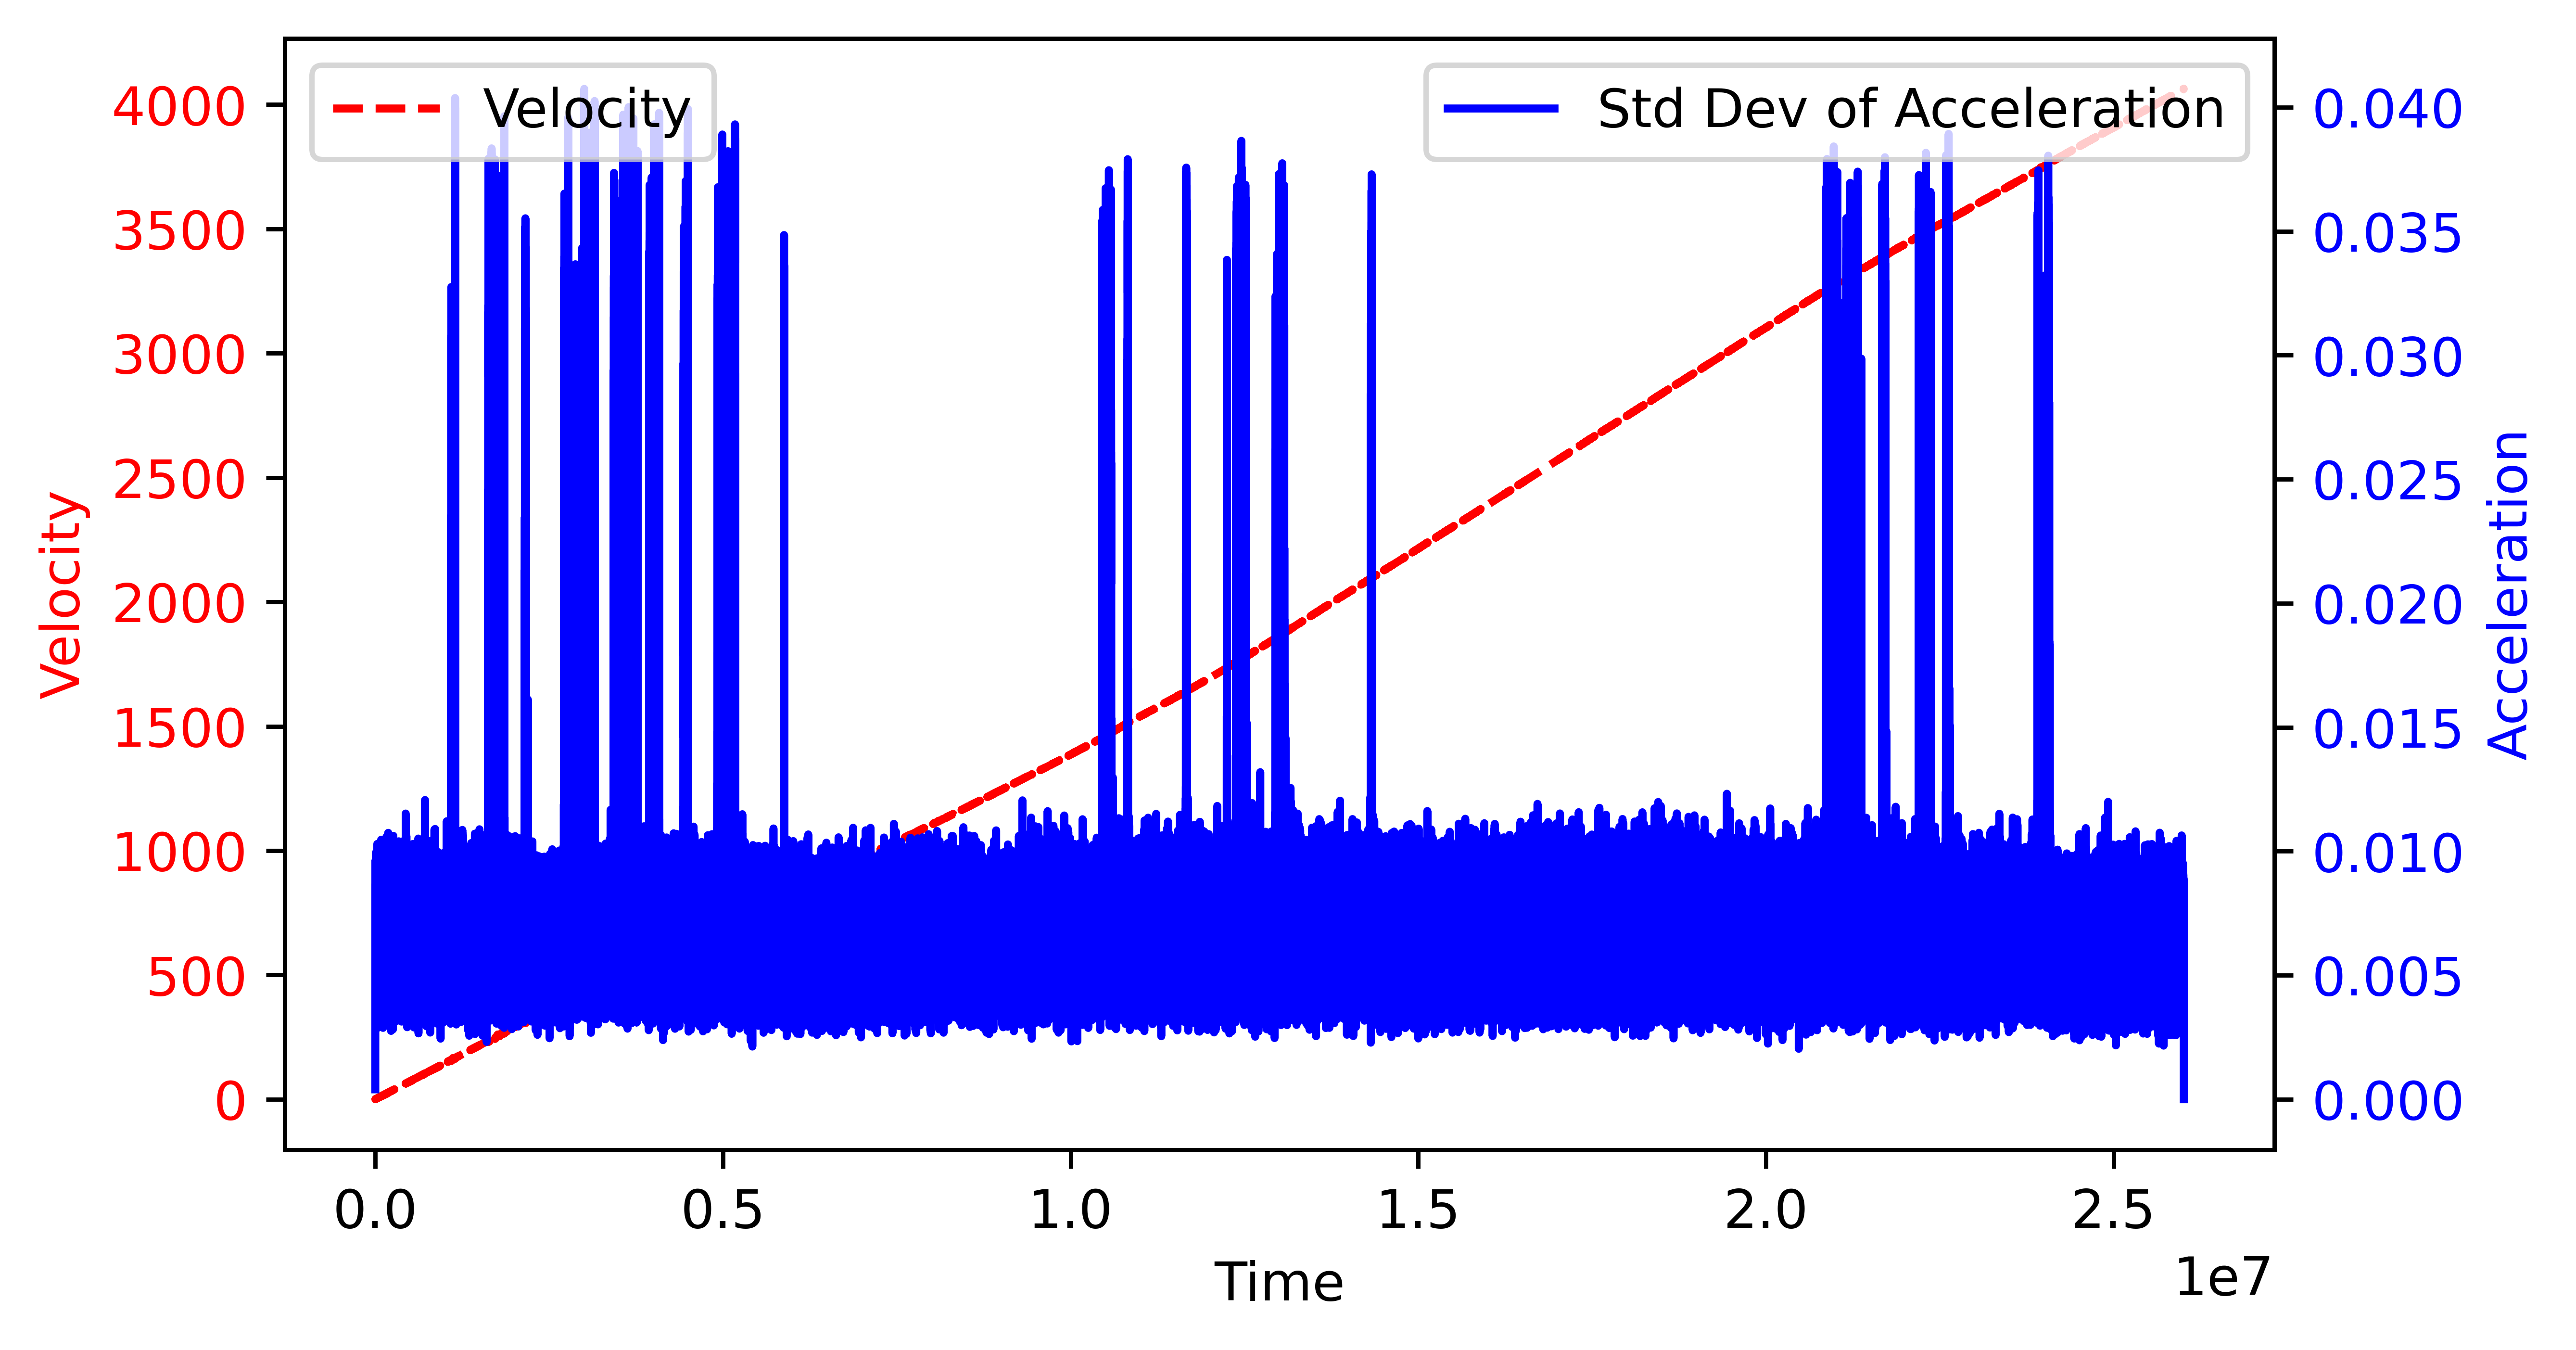

In [24]:
fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

PlotLength = min(len(Velocities[f]), len(StdDevsY[f]))
v = Velocities[f][:PlotLength]
sd = StdDevsY[f][:PlotLength]

ax1.set_xlabel('Time') 
ax1.set_ylabel('Velocity', color = 'red') 
ax1.plot(range(PlotLength), v, color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
legend_1 = ax1.legend(loc=2)
legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Acceleration', color = 'blue') 
ax2.plot(range(PlotLength), sd, color = 'blue', label='Std Dev of Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
ax2.legend(loc=1)
ax2.add_artist(legend_1)
# Show plot

plt.show()

In [ ]:
start = 3800000
length = 200000
end = start+length

In [ ]:
fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

ax1.set_xlabel('Time') 
ax1.set_ylabel('m/s', color = 'red') 
#ax1.plot(range(length), Velocity[start:end], color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.plot(range(length), Velocities[f][start:end], color = 'red', linestyle = 'dashed', label='Velocity' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
legend_1 = ax1.legend(loc=2)
legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Acceleration', color = 'blue') 
ax2.plot(range(length), StdDevsY[f][start:end], color = 'blue', label='g of Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
ax2.legend(loc=1)
ax2.add_artist(legend_1)
# Show plot

plt.show()

In [ ]:
for i in range(len(MaxDevZ)):
    print(NewFiles[i],MaxDevX[i], MaxRollX[i],MaxDevY[i], MaxRollY[i],MaxDevZ[i], MaxRollZ[i])

In [ ]:
Results = []
for i in range(len(MaxDevZ)):
    if MaxDevX[i] != 0:
        UnitSpeeds = np.abs(Velocities[i]).astype('int')
        MovingDevX = StdDevsX[i][np.abs(Velocities[i]) > 1]
        StopedDevX = StdDevsX[i][np.abs(Velocities[i]) < 1]
        MovingDevY = StdDevsY[i][np.abs(Velocities[i]) > 1]
        StopedDevY = StdDevsY[i][np.abs(Velocities[i]) < 1]
        MovingDevZ = StdDevsZ[i][np.abs(Velocities[i]) > 1]
        StopedDevZ = StdDevsZ[i][np.abs(Velocities[i]) < 1]
        DevX0 = np.average(StdDevsX[i][UnitSpeeds < 1])
        DevX1 = np.average(StdDevsX[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
        DevX2 = np.average(StdDevsX[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
        DevX3 = np.average(StdDevsX[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
        DevX4 = np.average(StdDevsX[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
        DevX5p = np.average(StdDevsX[i][UnitSpeeds >= 1])
        DevY0 = np.average(StdDevsY[i][UnitSpeeds < 1])
        DevY1 = np.average(StdDevsY[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
        DevY2 = np.average(StdDevsY[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
        DevY3 = np.average(StdDevsY[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
        DevY4 = np.average(StdDevsY[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
        DevY5p = np.average(StdDevsY[i][UnitSpeeds >= 5])
        DevZ0 = np.average(StdDevsZ[i][UnitSpeeds < 1])
        DevZ1 = np.average(StdDevsZ[i][(UnitSpeeds < 2) & (UnitSpeeds >= 1)])
        DevZ2 = np.average(StdDevsZ[i][(UnitSpeeds < 3) & (UnitSpeeds >= 2)])
        DevZ3 = np.average(StdDevsZ[i][(UnitSpeeds < 4) & (UnitSpeeds >= 3)])
        DevZ4 = np.average(StdDevsZ[i][(UnitSpeeds < 5) & (UnitSpeeds >= 4)])
        DevZ5p = np.average(StdDevsZ[i][UnitSpeeds >= 5])
        
        if NewFiles[i][16:17] == 'a':
            am = 1
        else:
            am = 0
        
        Results.append([int(NewFiles[i][:2]), int(NewFiles[i][2:4]), int(NewFiles[i][4:6]), int(NewFiles[i][16:17]), am, np.average(MovingDevX), np.average(StopedDevX), 
                        np.average(MovingDevY), np.average(StopedDevY), np.average(MovingDevY), 
                        np.average(StopedDevY), DevX0, DevX1, DevX2, DevX3, DevX4, DevX5p,
                        DevY0, DevY1, DevY2, DevY3, DevY4, DevY5p,
                        DevZ0, DevZ1, DevZ2, DevZ3, DevZ4, DevZ5p])
        
        print(NewFiles[i], np.average(MovingDevX)/np.average(StopedDevX), 
          np.average(MovingDevY)/np.average(StopedDevY), np.average(MovingDevY)/np.average(StopedDevY))

In [ ]:
7+3
